In [66]:
import pandas as pd
import sys
sys.path.insert(0, '../src/')
import importlib
import read_data
importlib.reload(read_data)
from read_data import load_dataset, load_commodity
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


In [67]:
df = load_dataset()

In [68]:
df_carne = load_commodity('Carne Vacuna')
df_trigo = load_commodity('Trigo')
df_soja = load_commodity('Soja')

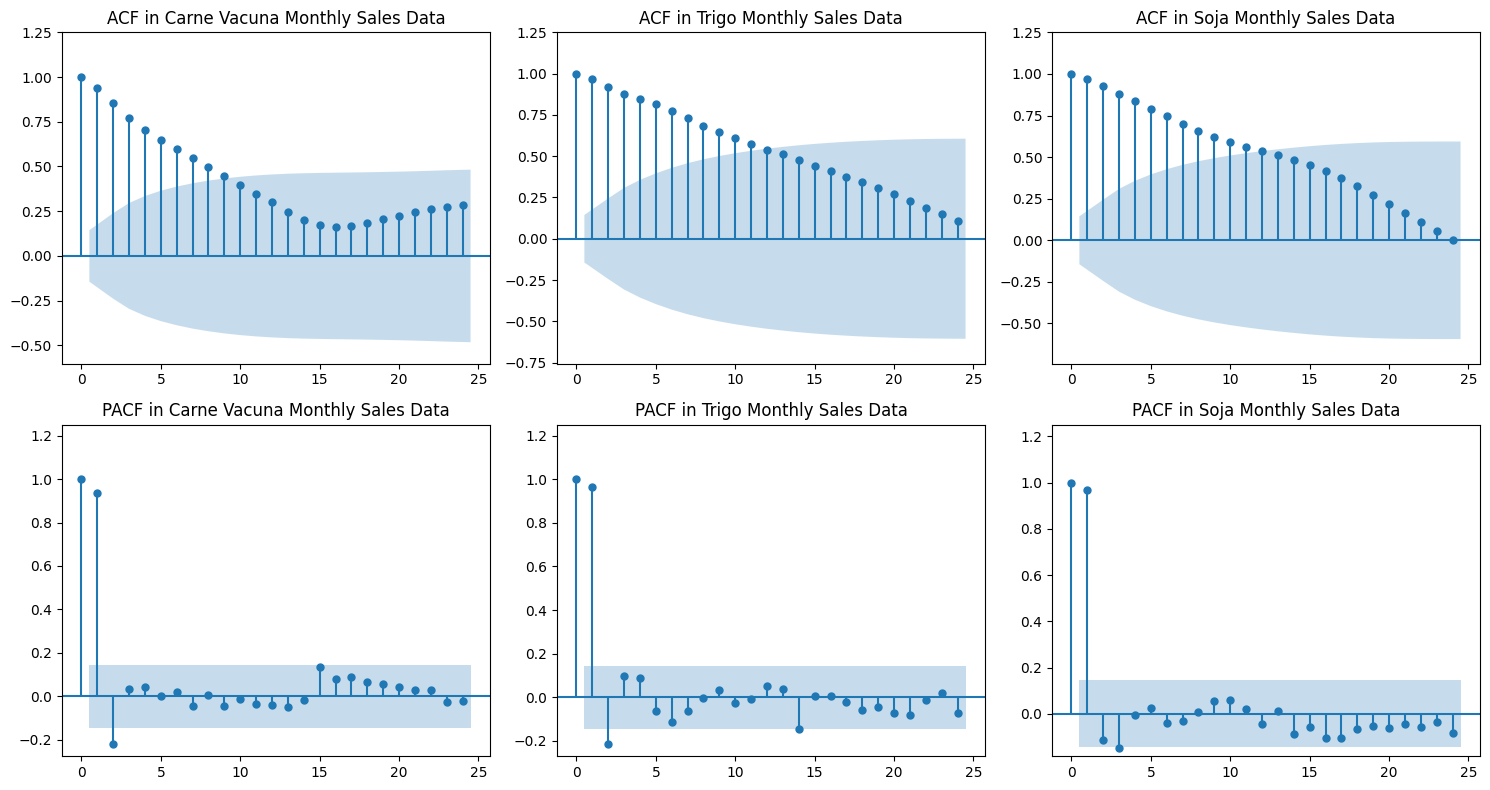

In [70]:
categories = ['Carne Vacuna', 'Trigo', 'Soja']
fig, axes = plt.subplots(2,3, figsize=(15,8))
for i, cat in enumerate(categories):
    plot_acf(df[cat], ax=axes[0,i], lags=24, title=f'ACF in {cat} Monthly Sales Data', auto_ylims=[-0.50,1.1])
    plot_pacf(df[cat], ax=axes[1,i], lags=24, title=f'PACF in {cat} Monthly Sales Data', auto_ylims=[-0.50,1.1])
plt.tight_layout()

In [71]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df_carne, regression='c')
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -1.7658775752220035
p-value: 0.3975292229149191


In [72]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df_trigo, regression='c')
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -2.2010872594795234
p-value: 0.20585108107166278


In [73]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df_soja, regression='c')
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -1.6408907414196505
p-value: 0.46179539244571544


In [74]:
import numpy as np
df['Carne_Log'] = np.log1p(df['Carne Vacuna'])
df['Trigo_Log'] = np.log1p(df['Trigo'])
df['Soja_Log'] = np.log1p(df['Soja'])


In [75]:
diff1_carne = df['Carne_Log'].diff()
diff1_trigo = df['Trigo_Log'].diff()
diff1_soja = df['Soja_Log'].diff()

In [76]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(diff1_carne[1:], regression='c')
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -9.649082484682962
p-value: 1.4510078340437015e-16


In [77]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(diff1_trigo[1:], regression='c')
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -11.18283116504206
p-value: 2.476448475754061e-20


In [78]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(diff1_soja[1:], regression='c')
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -12.111762886662495
p-value: 1.9121510762429227e-22


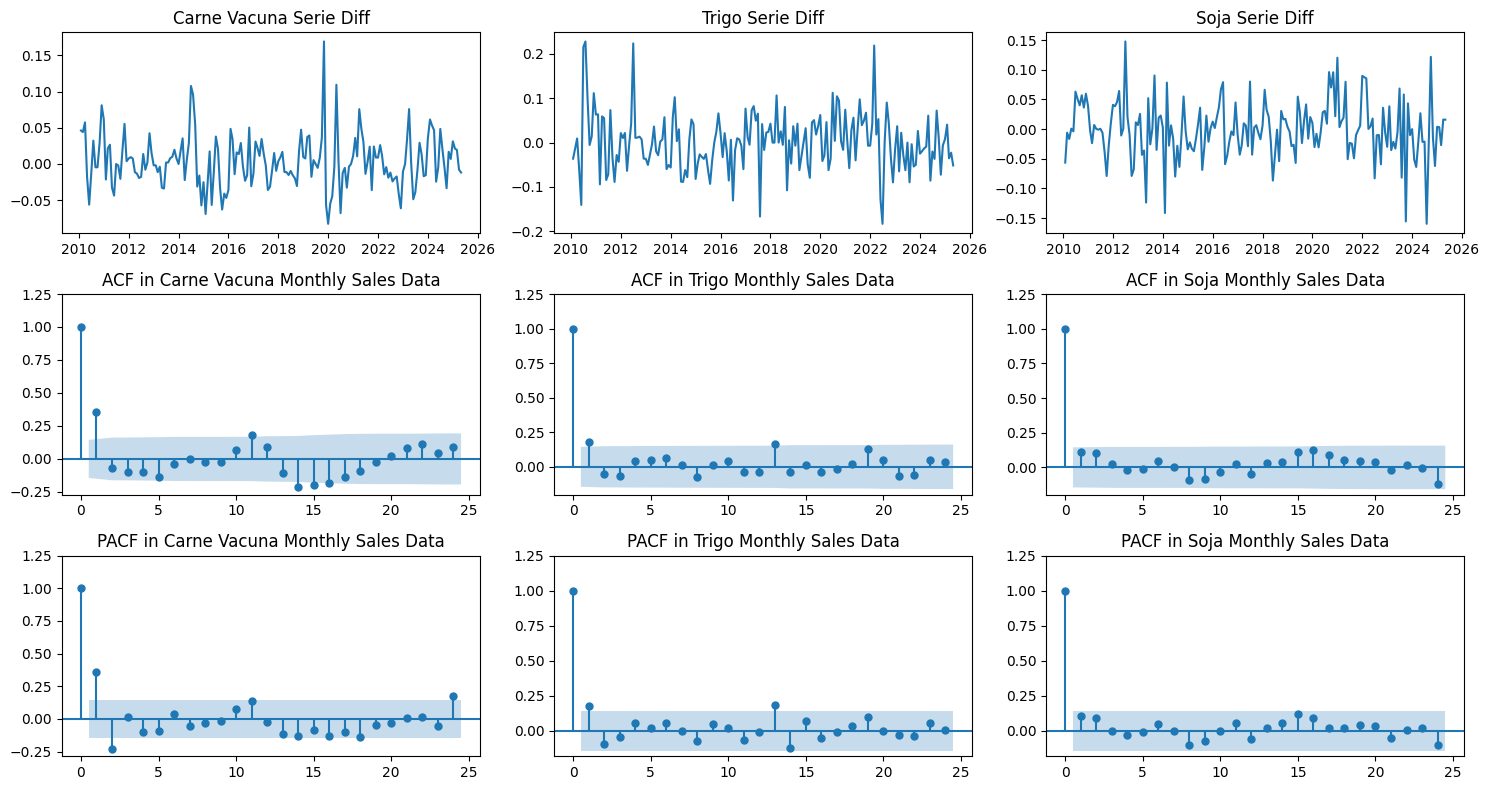

In [79]:
fig, axes = plt.subplots(3,3, figsize=(15,8))
axes[0,0].plot(diff1_carne[1:])
axes[0,0].set_title('Carne Vacuna Serie Diff')
plot_acf(diff1_carne[1:], ax=axes[1,0], lags=24, title=f'ACF in Carne Vacuna Monthly Sales Data', auto_ylims=[-0.50,1.1])
plot_pacf(diff1_carne[1:], ax=axes[2,0], lags=24, title=f'PACF in Carne Vacuna Monthly Sales Data', auto_ylims=[-0.50,1.1])
axes[0,1].plot(diff1_trigo[1:])
axes[0,1].set_title('Trigo Serie Diff')
plot_acf(diff1_trigo[1:], ax=axes[1,1], lags=24, title=f'ACF in Trigo Monthly Sales Data', auto_ylims=[-0.50,1.1])
plot_pacf(diff1_trigo[1:], ax=axes[2,1], lags=24, title=f'PACF in Trigo Monthly Sales Data', auto_ylims=[-0.50,1.1])
axes[0,2].plot(diff1_soja[1:])
axes[0,2].set_title('Soja Serie Diff')
plot_acf(diff1_soja[1:], ax=axes[1,2], lags=24, title=f'ACF in Soja Monthly Sales Data', auto_ylims=[-0.50,1.1])
plot_pacf(diff1_soja[1:], ax=axes[2,2], lags=24, title=f'PACF in Soja Monthly Sales Data', auto_ylims=[-0.50,1.1])
plt.tight_layout()

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_test_ARIMA(serie, name, order, seasonal_order, exog=None, log=True):

    train_size = int(len(serie) * 0.80)
    if exog is None:
        exog_train = None
        exog_test = None
    else:
        exog_train = exog.iloc[:train_size]
        exog_test = exog.iloc[train_size:]
        

    
    train, test = serie.iloc[:train_size], serie.iloc[train_size:]
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order, exog=exog_train)
    model = model.fit(maxiter=1000)



    predictions = model.predict(start=test.index.min(), end=test.index.max(), exog=exog_test)
    pred_train = model.predict(start=train.index.min(), end=train.index.max(), exog=exog_train)

    if log:
        test = np.exp(test)
        train = np.exp(train)
        predictions = np.exp(predictions)
        pred_train = np.exp(pred_train)

    mae_test = mean_absolute_error(test, predictions)
    rmse_test = np.sqrt(mean_squared_error(test, predictions))
    mape_test = np.mean(np.abs((test - predictions) / test)) * 100

    mae_train = mean_absolute_error(train, pred_train)
    rmse_train = np.sqrt(mean_squared_error(train, pred_train))
    mape_train = np.mean(np.abs((train - pred_train) / train)) * 100



    print(f"MAE_test: {mae_test}")
    print(f"RMSE_test: {rmse_test}")
    print(f"MAPE_test: {mape_test:.2f}%")

    print(f"MAE_train {mae_train}")
    print(f"RMSE_train: {rmse_train}")
    print(f"MAPE_train: {mape_train:.2f}%")

    # Gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train)
    #plt.plot(train.index[1:], pred_train[1:])
    plt.plot(test.index, test, label=f'Real (Testing Set) - {name}', color='red')
    plt.plot(test.index, predictions, label=f'Prediction (Testing Set) - {name}', color='blue')
    plt.legend()
    plt.title(f'Predictions with ARIMA - {name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

### Forecasting Carne Vacuna

MAE_test: 0.90222201516821
RMSE_test: 1.0159428460585542
MAPE_test: 17.19%
MAE_train 0.17887640887346298
RMSE_train: 0.33786555513912925
MAPE_train: 4.11%


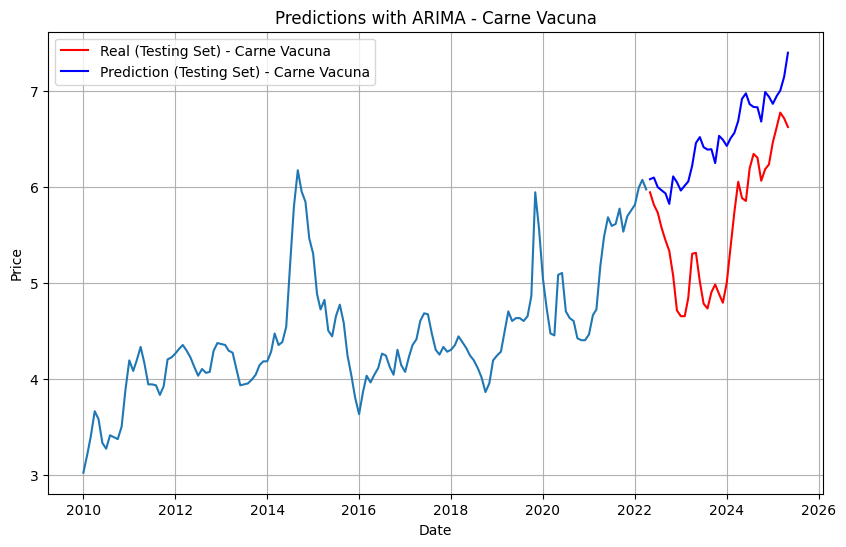

In [464]:
train_test_ARIMA(np.log(df['Carne Vacuna']), 'Carne Vacuna', (1,1,1), (1,1,1,12))

MAE_test: 0.6682815372609705
RMSE_test: 0.8141542816510041
MAPE_test: 13.08%
MAE_train 0.16876136897431307
RMSE_train: 0.31188143332363355
MAPE_train: 3.92%


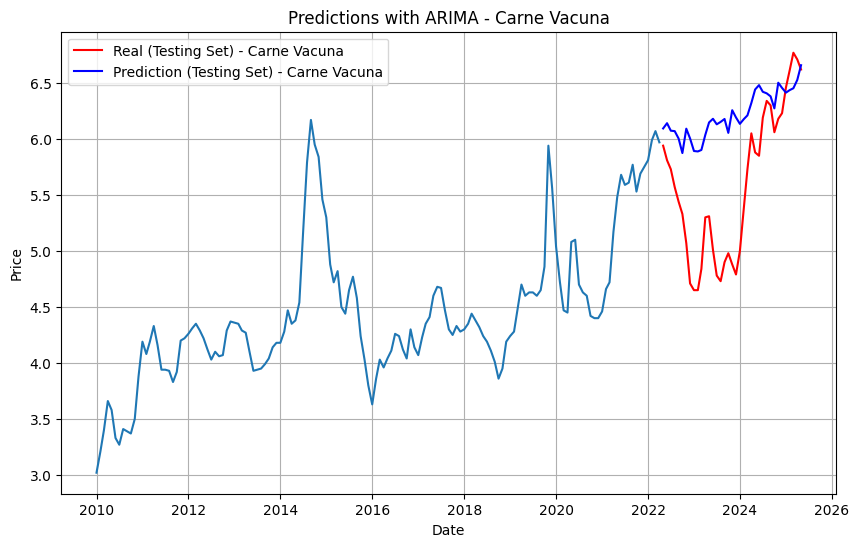

In [474]:
train_test_ARIMA(df['Carne Vacuna'], 'Carne Vacuna', (1,1,1), (1,1,1,12), exog=df['Energy'], log=False)

MAE_test: 0.6680774688801219
RMSE_test: 0.8091884412637179
MAPE_test: 13.04%
MAE_train 0.1670271344393173
RMSE_train: 0.27540747950543576
MAPE_train: 3.81%


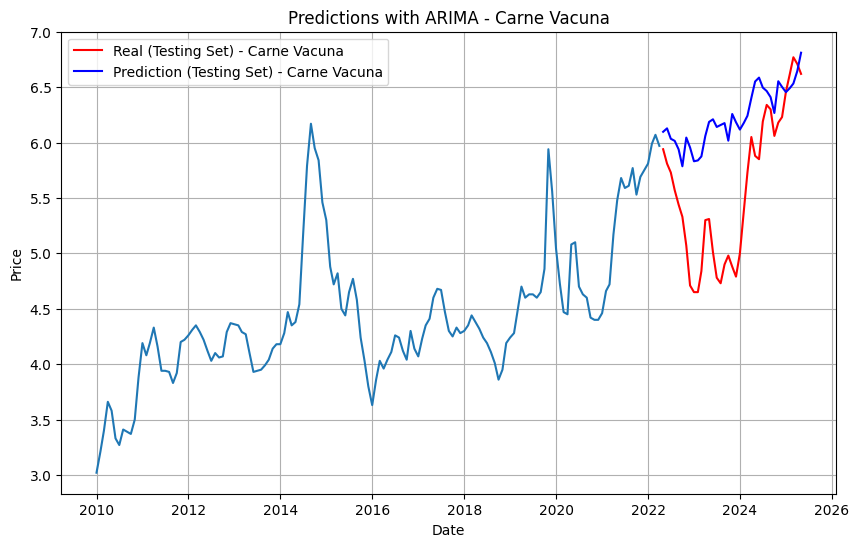

In [475]:
train_test_ARIMA(np.log(df['Carne Vacuna']), 'Carne Vacuna', (1,1,1), (1,1,1,12), exog=np.log(df['Energy']))

In [491]:
exog = pd.DataFrame(index=df.index)
#exog['log_maiz'] = np.log(df['Maiz'])
exog['log_energia'] = np.log(df['Energy'])
exog['oro'] = np.log(df['Oro'])

#exog['maiz_lag1'] = df['Maiz'].shift(1)
#exog['metal'] = np.log(df['Metal Index'])
# Variables dummies de mes (estacionalidad)
#exog['mes'] = df.index.month
#exog = pd.get_dummies(exog, columns=['mes'], drop_first=True)
#exog = exog.astype(float)


In [484]:
df_train = pd.concat([exog, np.log(df['Carne Vacuna'])], axis=1)
df_train.corr()

,log_energia,oro,Carne Vacuna
log_energia,1.000000,0.248614,0.116836
oro,0.248614,1.000000,0.676529
Carne Vacuna,0.116836,0.676529,1.000000


MAE_test: 0.6353186174788951
RMSE_test: 0.7708284116862341
MAPE_test: 12.41%
MAE_train 0.14809227167426572
RMSE_train: 0.20549281125093094
MAPE_train: 3.27%


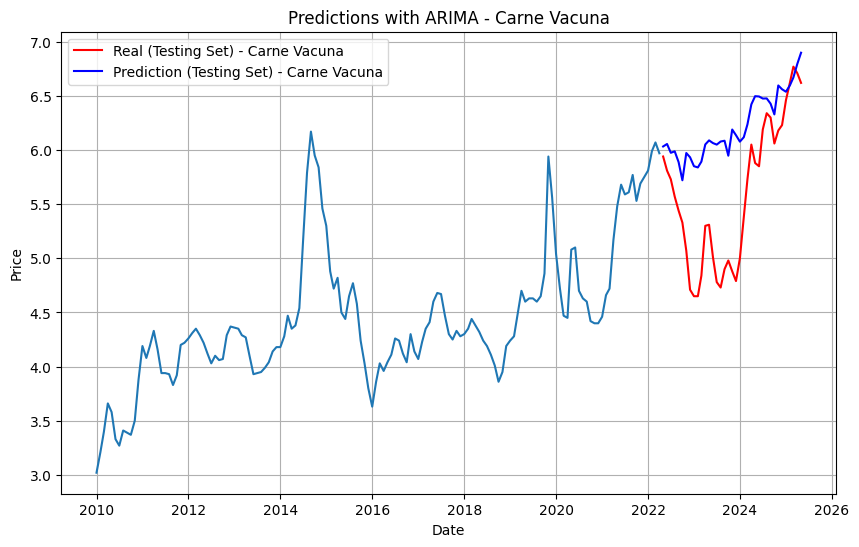

In [492]:
train_test_ARIMA(np.log(df['Carne Vacuna']), 'Carne Vacuna', (0,1,1), (0,1,1,12), exog=exog)

In [359]:
train_size = int(len(np.log(df['Carne Vacuna'])) * 0.8)
train, test = np.log(df['Carne Vacuna']).iloc[:train_size], np.log(df['Carne Vacuna']).iloc[train_size:]

In [415]:
from pmdarima import auto_arima

modelo_auto = auto_arima(train, exogenous=exog.iloc[:train_size],
                         seasonal=True,         # ¡importante!
                         m=12,                  # frecuencia estacional (mensual)
                         d=1,                # que lo detecte
                         D=1,                # que lo detecte también
                         max_D=1,               # máxima diferenciación estacional
                         stepwise=True,
                         trace=True,
                         suppress_warnings=True,
                         error_action='ignore')
print(modelo_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-455.468, Time=5.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-379.592, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-433.627, Time=0.45 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-458.030, Time=1.79 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-395.160, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-457.770, Time=2.24 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-457.646, Time=2.50 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-440.067, Time=0.37 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=3.63 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-430.683, Time=0.74 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-456.088, Time=3.05 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-456.103, Time=2.23 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-451.424, Time=1.29 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-456.279, Time=3.22 sec
 ARIMA(0,1,1)(0,1,1)[12]

In [493]:

train_size = int(len(df['Carne Vacuna']) * 0.80)
serie = np.log(df['Carne Vacuna'])
train, test = serie.iloc[:train_size], serie.iloc[train_size:]
model_carne = SARIMAX(train, order=(0,1,1), seasonal_order=(0,1,1,12), exog=exog.iloc[:train_size])
model_carne = model_carne.fit(maxiter=1000)


### Forecasting Soja

In [84]:
exog = pd.DataFrame(index=df.index)
exog['log_maiz'] = np.log(df['Maiz'])
exog['log_energia'] = np.log(df['Energy'])
#exog['oro'] = np.log(df['Oro'])
exog['Trigo'] = np.log(df['Trigo'])
#exog['maiz_lag1'] = df['Maiz'].shift(1)
exog['metal'] = np.log(df['Metal Index'])
# Variables dummies de mes (estacionalidad)
#exog['mes'] = df.index.month
#exog = pd.get_dummies(exog, columns=['mes'], drop_first=True)
#exog = exog.astype(float)


In [81]:
df_train = pd.concat([df['Soja'], exog], axis=1)

In [82]:
df_train.corr()

,Soja,log_maiz,log_energia,oro,Trigo,metal
Soja,1.000000,0.896620,0.718720,0.378573,0.877471,0.447145
log_maiz,0.896620,1.000000,0.754036,0.421954,0.874892,0.515625
log_energia,0.718720,0.754036,1.000000,0.248614,0.754599,0.341535
oro,0.378573,0.421954,0.248614,1.000000,0.496185,0.984019
Trigo,0.877471,0.874892,0.754599,0.496185,1.000000,0.552357
metal,0.447145,0.515625,0.341535,0.984019,0.552357,1.000000


MAE_test: 63.046668969289165
RMSE_test: 84.22866672341274
MAPE_test: 13.85%
MAE_train 38.194530986474184
RMSE_train: 265.7716971340595
MAPE_train: 7.31%


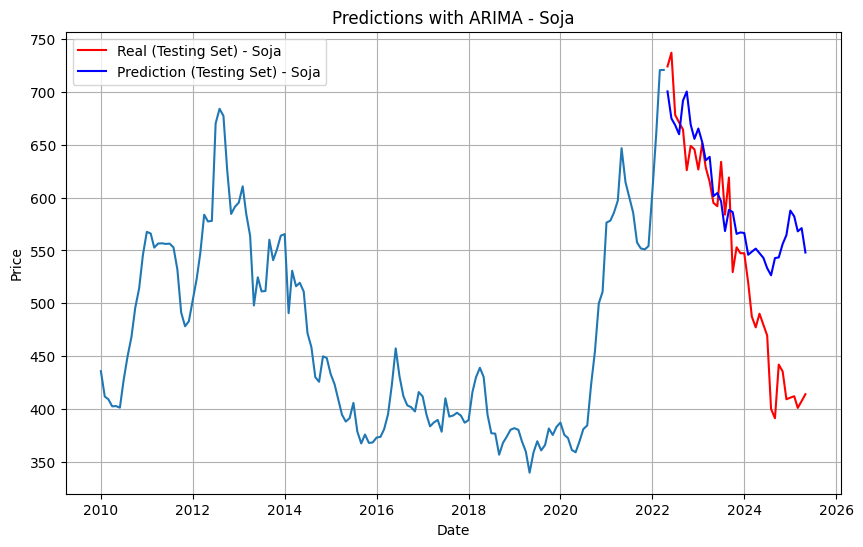

In [85]:
train_test_ARIMA(np.log(df['Soja']), 'Soja', (2,1,2), (0,1,2,12), exog)

In [86]:
from pmdarima import auto_arima
train_size = int(len(np.log(df['Soja'])) * 0.8)
train, test = np.log(df['Soja']).iloc[:train_size], np.log(df['Soja']).iloc[train_size:]

modelo_auto = auto_arima(train,
                         exogenous=exog.iloc[:train_size],
                         seasonal=True,         # ¡importante!
                         m=12,                  # frecuencia estacional (mensual)
                         d=1,                # que lo detecte
                         D=1,                # que lo detecte también
                         max_D=1,               # máxima diferenciación estacional
                         stepwise=True,
                         trace=True,
                         suppress_warnings=True,
                         error_action='ignore')
print(modelo_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-418.941, Time=3.70 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-348.624, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-382.697, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.33 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=inf, Time=3.46 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=-392.658, Time=2.30 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=inf, Time=5.79 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=inf, Time=6.19 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=-422.543, Time=5.51 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=inf, Time=5.54 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=inf, Time=6.22 sec
 ARIMA(3,1,2)(0,1,2)[12]             : AIC=inf, Time=7.24 sec
 ARIMA(2,1,3)(0,1,2)[12]             : AIC=-422.481, Time=11.57 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=5.23 

### Forecasting Trigo

In [59]:
import numpy as np
exog = pd.DataFrame(index=df.index)
exog['log_maiz'] = np.log(df['Maiz'])
exog['log_energia'] = np.log(df['Energy'])
#exog['oro'] = np.log(df['Oro'])
exog['log_soja'] = np.log(df['Soja'])
#exog['Trigo'] = np.log(df['Trigo'])
#exog['maiz_lag1'] = df['Maiz'].shift(1)
exog['metal'] = np.log(df['Metal Index'])
# Variables dummies de mes (estacionalidad)
#exog['mes'] = df.index.month
#exog = pd.get_dummies(exog, columns=['mes'], drop_first=True)
#exog = exog.astype(float)

In [58]:
df_train = pd.concat([exog, np.log(df['Trigo'])], axis=1)
df_train.corr()

,log_maiz,log_energia,oro,log_soja,metal,Trigo
log_maiz,1.000000,0.754036,0.421954,0.896038,0.515625,0.874892
log_energia,0.754036,1.000000,0.248614,0.731161,0.341535,0.754599
oro,0.421954,0.248614,1.000000,0.381708,0.984019,0.496185
log_soja,0.896038,0.731161,0.381708,1.000000,0.457037,0.877558
metal,0.515625,0.341535,0.984019,0.457037,1.000000,0.552357
Trigo,0.874892,0.754599,0.496185,0.877558,0.552357,1.000000


In [61]:
from pmdarima import auto_arima
train_size = int(len(np.log(df['Trigo'])) * 0.8)
train, test = np.log(df['Trigo']).iloc[:train_size], np.log(df['Trigo']).iloc[train_size:]

modelo_auto = auto_arima(train,
                         exogenous=exog.iloc[:train_size],
                         seasonal=True,         # ¡importante!
                         m=12,                  # frecuencia estacional (mensual)
                         d=1,                # que lo detecte
                         D=1,                # que lo detecte también
                         max_D=1,               # máxima diferenciación estacional
                         stepwise=True,
                         trace=True,
                         suppress_warnings=True,
                         error_action='ignore')
print(modelo_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=4.35 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-263.034, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-300.528, Time=0.44 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.42 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-261.631, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-308.291, Time=0.76 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.30 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.24 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-305.462, Time=0.48 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-306.807, Time=0.96 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-306.618, Time=1.25 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-308.617, Time=0.75 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-300.672, Time=0.40 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=2.68 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=i

MAE_test: 59.765912634063746
RMSE_test: 63.9537945348703
MAPE_test: 20.21%
MAE_train 14.277059899673974
RMSE_train: 25.65610712060268
MAPE_train: 5.56%


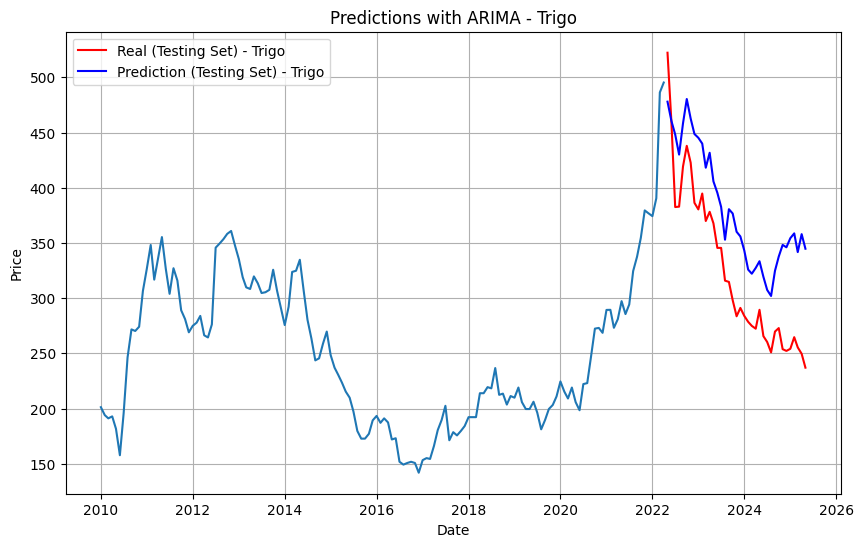

In [65]:
train_test_ARIMA(np.log(df['Trigo']), 'Trigo', (1,1,1), (1,1,1,12), exog)